In [1]:
import netCDF4 as nc
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

# Idealized bathymetry function

In [2]:
def widthprofile(y, y_base, y_head, y_coast, cR, L, p, w_break, w_mid, w_head):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head
                #wp[l] = Ah * (y[l] - y_head)**1 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile

# ------------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
                     cR, L, p, x, x_wall, w_break, w_mid, w_head,
                     fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_paral: Distance to where isobaths start bending into canyon
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_paral: Depth of first isobath bending into canyon
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_coast: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = functions_idealized.tanktopo(y, y_base, y_break, y_coast, fluid_depth, 
                             z_bottom, z_break, z_coast)
    
    canyon_profile = functions_idealized.canyontopo(y, y_base, y_paral, y_pointA, y_pointB, y_head, y_coast,
                                fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_head, y_coast, cR, L, p, w_break, w_mid, w_head)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    topo = -1* topography[0:-1, :]
    topo = np.fliplr(np.rot90(topo, 2))
   
    return topo

In [3]:
xsize, ysize, x_wall, y_wall = 238, 178, 547219.33445374772, 406382.26879306574

In [4]:
x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = make_topo_smooth(y_edge, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
                                               cR, L, p, x, x_wall, w_break, w_mid, w_head,
                                               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)

0.0083214


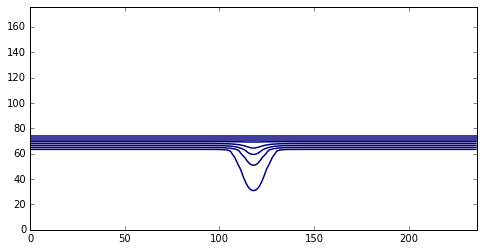

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
c1 = ax.contour(z_ideal, 10, colors='Navy', linewidths=1.5)

print((9e-7) * cR)

# Circle Method

In [6]:
real = nc.Dataset('../NEMO_files/realistic/real_bathy_02.nc')['Bathymetry']
ideal = nc.Dataset('../NEMO_files/idealized/ideal_bathy_05.nc')['Bathymetry']

In [7]:
radius = 19

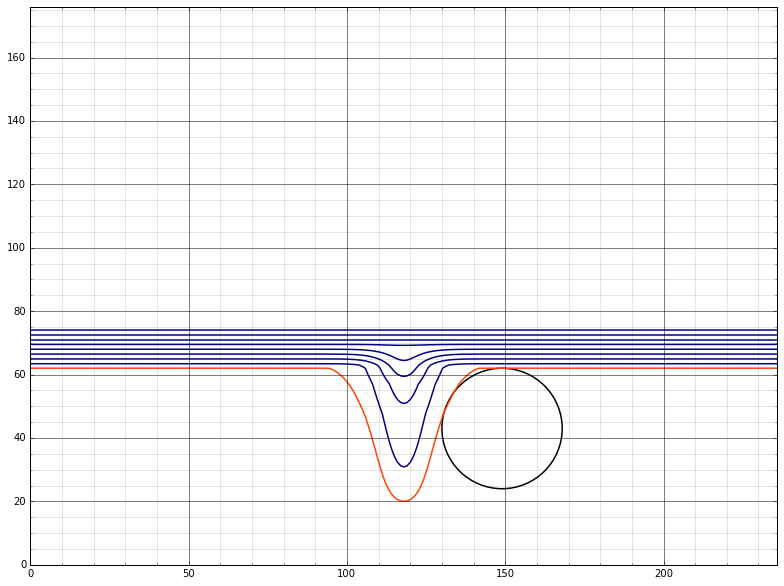

In [12]:
fig, ax = plt.subplots(1,1,figsize=(ideal.shape[1]/ideal.shape[0]*10,10))
ax.contour(ideal[:,:], 10, colors='Navy', linewidths=1.5)
ax.contour(ideal[:,:], levels=[80], colors='orangered', linewidths=1.5)

plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='-', alpha=0.2)
plt.minorticks_on()

circle = Circle((149, 43), radius, facecolor='none', edgecolor='k', linewidth=1.5)
ax.add_patch(circle)

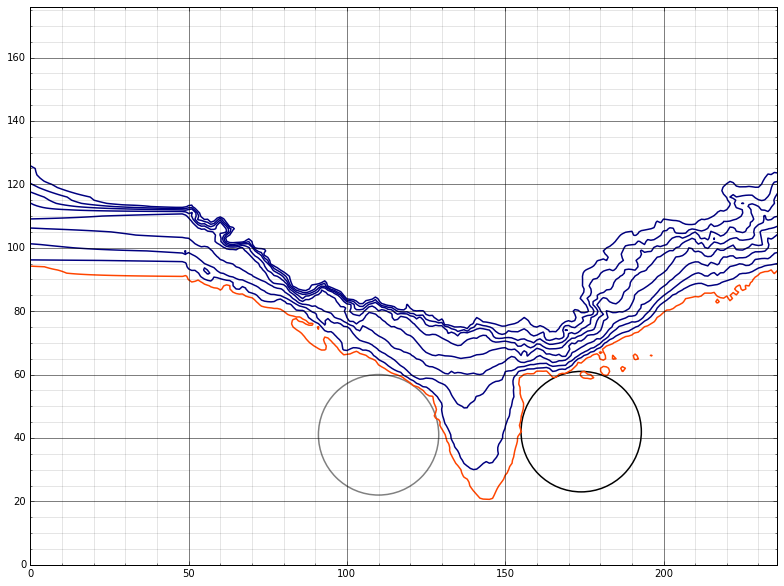

In [16]:
fig, ax = plt.subplots(1,1,figsize=(real.shape[1]/real.shape[0]*10,10))
ax.contour(real[:,:], 10, colors='Navy', linewidths=1.5)
ax.contour(real[:,:], levels=[80], colors='orangered', linewidths=1.5)

plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='-', alpha=0.2)
plt.minorticks_on()

circle = Circle((174, 42), radius, facecolor='none', edgecolor='k', linewidth=1.5)
ax.add_patch(circle)

circled = Circle((110, 41), radius, facecolor='none', edgecolor='gray', linewidth=1.5)
ax.add_patch(circled)

In [14]:
# from final_bathymetry
d_grid = 2.24129
radius_km = d_grid * radius

print(radius_km)

42.584509999999995
